In [1]:
# 참고 : https://sike6054.github.io/blog/paper/third-post/

# [Inception V2 & V3]

*KU LeeDongGyu*

## Contents
---

1. Data Preprocessing
```
1) Data Import
2) Data Augmentation
```
2. Support Functions & Almost Original Inception-V2,V3 (Especially V3)
```
1) Support Functions
2) Almost Original Inception-V2,V3 (Especially V3)
3) Inception-V3 Evaluate
```



### Install Packages


### Module

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/Colab Notebooks/Paper

/content/drive/My Drive/Colab Notebooks/Paper


In [4]:
from f1score import macro_f1score,weighted_f1score
from smoothed_categorical_crossentropy import smoothed_categorical_crossentropy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, ZeroPadding2D ,GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, BatchNormalization, AveragePooling2D , ZeroPadding2D, SeparableConv2D , LeakyReLU
from tensorflow.keras.layers import add, concatenate, multiply
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model , Sequential
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Paper'

In [7]:
print(tf.__version__)
print(ks.__version__)

2.3.0
2.4.0


In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3396141758410601757
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11860145278929263268
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8521971086961183796
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695488000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12440231254924879327
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [10]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

## 1. Data Preprocessing
---

### 1) Data Import

In [11]:
# 바꿔서 살펴 볼 것들
# CALTECH, CIFAR100, FER, MIT
data_name = 'CALTECH'
gan_type = 'No_GAN'
number = '1'
size = 299 # sizes after cropping
super_size = 330 # sizes before cropping 
input_sizes = (size,size,3)
batch_sizes = 64
weight_decay = 2e-3
epochs = 70

In [12]:
# 참고 : https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras/52897216#52897216
# setting the seed number for random number generation for reproducibility.

from numpy.random import seed
import random


if number=='1':
    seed_num = 200225
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='2':
    seed_num = 727
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='3':
    seed_num = 115
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='4':
    seed_num = 501
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
elif number=='5':
    seed_num = 517
    os.environ['PYTHONHASHSEED']=str(seed_num)
    random.seed(seed_num)
    seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [13]:
# data import

if data_name=='FER' :
    x_train =  np.zeros(28698)
    x_valid = np.zeros(3589)
    x_test = np.zeros(3588)
    classes = 7 
    tr_center = [0.50793296, 0.50793296, 0.50793296]
elif data_name=='MIT':
    x_train = np.zeros(12466)
    x_valid = np.zeros(1564)
    x_test = np.zeros(1590)
    classes = 67 
    tr_center = [0.47916578, 0.42029615, 0.36046057]
elif data_name=='CALTECH':
    x_train = np.zeros(24510)
    x_valid = np.zeros(2980)
    x_test = np.zeros(3118)
    classes = 257
    tr_center = [0.51397761, 0.49525248, 0.46555727]
elif data_name=='CIFAR100':
    x_train = np.zeros(44923)
    x_valid = np.zeros(5077)
    x_test = np.zeros(10000)
    classes = 100
    tr_center = [0.53442983, 0.51355958, 0.46462564]

In [14]:
dir = os.path.join(os.getcwd(),data_name,gan_type)

### 2) Data Augmentation

In [15]:
# 참고 : https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3 # img.shape[2] 가 3(rgb)이 아니면 assertion error 발생
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]


def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

In [16]:
from tensorflow.keras.preprocessing.image import img_to_array,load_img
import glob

# 데이터 전체에 대해 centering 진행함.

def read_cal_image(img_path): 
    x = img_to_array(load_img(img_path)) # x는 채널별 평균값
    y = x.shape[0] * x.shape[1]# y는 데이터별 픽셀 수 (비중)

    x = 1/255. * x # scaling하고, centering값을 뽑아냄.
    x = np.mean(x, axis=(0,1))
    
    return np.hstack([x,y])

def calculate_centered_mean(dataset_path,x_train=x_train):
    num = len(x_train)
    space = np.empty((num,4))
    i=0

    for p in glob.glob(os.path.join(dataset_path,'*/*.*')) :
        space[i] = read_cal_image(p)
        i += 1

    ratio = space[:,3] / np.sum(space[:,3])

    return np.average(space[:,0:3],axis=0,weights=ratio)


# 아래의 함수를 돌려서 나온 결과값을 중심화 값으로 설정.

# train_mean = calculate_centered_mean(os.path.join(dir,'data/train')).reshape((1,1,3))

In [17]:
datagen_tr = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.9,1.0],
    fill_mode = 'nearest')
datagen_val = ImageDataGenerator(rescale=1/255.,featurewise_center=True)
datagen_tes = ImageDataGenerator(rescale=1/255.,featurewise_center=True)

# 원래는 이 자리에 fit 매서드를 써야하지만, 그냥 내가 중심화함수를 만들고 적용함. 

# 중심화 설정
datagen_tr.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_val.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB
datagen_tes.mean = np.array(tr_center, dtype=np.float32).reshape((1,1,3)) # RGB

In [18]:
# Inception-V2 & V3은 분류기가 2개이므로 imagedatagenerator 사용방법이 다소 다르다.
# model.fit에 다중 input으로 들어갈 함수를 개인이 만들어서 사용해야 하며, 그 함수는 아래와 같다. 
# 매우 간단하다.

#1. train data

def generate_train_for_two(crop_length=size, batch_sizes = batch_sizes, super_size=super_size):

      batches = datagen_tr.flow_from_directory(directory=os.path.join(dir,'data/train'),target_size=(super_size,super_size),batch_size=batch_sizes,class_mode='categorical')

      while True:
          batch_x, batch_y = next(batches)
          batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
          for i in range(batch_x.shape[0]):
              batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
          yield batch_crops, [batch_y,batch_y]


In [19]:
# 2. valid data

def generate_valid_for_two(size=size, batch_sizes = batch_sizes):

      batches_xy = datagen_val.flow_from_directory(directory=os.path.join(dir,'data/valid'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical')

      while True:

          batch_xy = batches_xy.next()
          yield  batch_xy[0], [ batch_xy[1],batch_xy[1] ]

In [20]:
# 3. test data

def generate_test_for_two(size=size, batch_sizes = batch_sizes):

      batches_xy = datagen_tes.flow_from_directory(directory=os.path.join(dir,'data/test'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical')

      while True:

          batch_xy = batches_xy.next()
          yield  batch_xy[0], [ batch_xy[1],batch_xy[1] ] 

In [21]:
# 위에서 쓰임
# train_batches = datagen_tr.flow_from_directory(directory=os.path.join(dir,'data/train'),target_size=(super_size,super_size),batch_size=batch_sizes,class_mode='categorical') # fer : 28698 / mit : 12466 / caltech : 24509 / cifar : 44923
# train_generator= crop_generator(train_batches, size)

# valid_generator = datagen_val.flow_from_directory(directory=os.path.join(dir,'data/valid'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3589 / mit : 1564 / caltech : 2980 / cifar : 5077
# test_generator = datagen_tes.flow_from_directory(directory=os.path.join(dir,'data/test'),target_size=(size,size),batch_size=batch_sizes,class_mode='categorical') # fer : 3588 / mit : 1590 / caltech : 3118 / cifar : 10000

## 2. Support Functions & Almost Original Inception-V2,V3 (Especially V3)
---

### 1) Support Functions

In [22]:
# def lr_schedule(epoch):
#     init_lr = 1e-4
#     k = 0.04
#     lr = init_lr * np.exp(-k*epoch)
#     print('Learning rate: ', lr)
#     return lr

def lr_schedule(epoch):
    lr = 1e-3
    if epoch < 30:
        lr = lr
    elif epoch < 60 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [23]:
def smoothed_categorical_crossentropy(y_true, y_pred): 
    if smoothing_param > 0:
        smooth_positives = 1.0 - smoothing_param 
        smooth_negatives = smoothing_param / classes 
        y_true = y_true * smooth_positives + smooth_negatives 

    return K.categorical_crossentropy(y_true, y_pred)


In [24]:
def conv2d_bn(x, filters, kernel_size, weight_decay=weight_decay, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, (kernel_size[0], kernel_size[1]), padding=padding, strides=strides, kernel_initializer='he_uniform', use_bias=False, kernel_regularizer=l2(weight_decay))(x)    
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

In [25]:
def inception_f3(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (3, 3))
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (3, 3))
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat

def inception_f6(input_tensor, filter_channels, n=7, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (1, n))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (n, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[3], (1, n))
    branch_1 = conv2d_bn(branch_1, filter_b1[4], (n, 1))
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (1, n))
    branch_2 = conv2d_bn(branch_2, filter_b2[2], (n, 1))
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat

def inception_f10(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2, filter_b3, filter_b4 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1a = conv2d_bn(branch_1, filter_b1[2][0], (1, 3))
    branch_1b = conv2d_bn(branch_1, filter_b1[2][1], (3, 1))
    branch_1 = Concatenate()([branch_1a, branch_1b])
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2a = conv2d_bn(branch_2, filter_b2[1][0], (1, 3))
    branch_2b = conv2d_bn(branch_2, filter_b2[1][1], (3, 1))
    branch_2 = Concatenate()([branch_2a, branch_2b])
    
    branch_3 = MaxPooling2D((3, 3), strides=1, padding='same')(input_tensor)
    branch_3 = conv2d_bn(branch_3, filter_b3, (1, 1))
    
    branch_4 = conv2d_bn(input_tensor, filter_b4, (1, 1))
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if not name==None else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    return filter_concat
    
def inception_dim_reduction(input_tensor, filter_channels, name=None):
    filter_b1, filter_b2 = filter_channels
    
    branch_1 = conv2d_bn(input_tensor, filter_b1[0], (1, 1))
    branch_1 = conv2d_bn(branch_1, filter_b1[1], (3, 3))
    branch_1 = conv2d_bn(branch_1, filter_b1[2], (3, 3), strides=2)
    
    branch_2 = conv2d_bn(input_tensor, filter_b2[0], (1, 1))
    branch_2 = conv2d_bn(branch_2, filter_b2[1], (3, 3), strides=2)
    
    branch_3 = MaxPooling2D((3, 3), strides=2, padding='same')(input_tensor)
    
    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3]) if not name==None else Concatenate()([branch_1, branch_2, branch_3])
    
    return filter_concat


### 2) Almost Original Inception-V2,V3 (Especially V3)

In [26]:
def Inception_v3(model_input, name, weight_decay= weight_decay):
    x = conv2d_bn(model_input, 32, (3, 3), padding='valid', strides=2) # (299, 299, 3) -> (149, 149, 32)
    x = conv2d_bn(x, 32, (3, 3), padding='valid') # (147, 147, 32) -> (147, 147, 32)
    x = conv2d_bn(x, 64, (3, 3), padding='same') # (147, 147, 32) -> (147, 147, 64)
    
    x = MaxPooling2D((3, 3), strides=2, padding='valid')(x) # (147, 147, 64) -> (73, 73, 64)
    
    x = conv2d_bn(x, 80, (3, 3), padding='valid') # (73, 73, 64) -> (71, 71, 80)
    x = conv2d_bn(x, 192, (3, 3), padding='valid', strides=2) # (71, 71, 80) -> (35, 35, 192)
    x = conv2d_bn(x, 288, (3, 3), padding='same') # (35, 35, 192) -> (35, 35, 288)
    
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64]) # (35, 35, 288)
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64]) # (35, 35, 288)
    x = inception_f3(x, [[64, 96, 96], [48, 64], 64 , 64], name='block_inception_f3') # (35, 35, 288)
    
    x = inception_dim_reduction(x, [[64, 96, 96], [256, 384]], name='block_reduction_1') # (35, 35, 288) -> (17, 17, 768)
    
    x = inception_f6(x, [[128, 128, 128, 128, 192], [128, 128, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[160, 160, 160, 160, 192], [160, 160, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[160, 160, 160, 160, 192], [160, 160, 192], 192, 192]) # (17, 17, 768)
    x = inception_f6(x, [[192, 192, 192, 192, 192], [192, 192, 192], 192, 192]) # (17, 17, 768)
    x_a = inception_f6(x, [[192, 192, 192, 192, 192], [192, 192, 192], 192, 192], name='block_inception_f6') # (17, 17, 768)
    
    x = inception_dim_reduction(x_a, [[128, 192, 192], [192, 320]], name='block_reduction_2') # (17, 17, 768) -> (8, 8, 1280)
    
    x = inception_f10(x, [[448, 384, [384, 384]], [384, [384, 384]], 192, 320]) # (8, 8, 1280) -> (8, 8, 2048)
    x = inception_f10(x, [[448, 384, [384, 384]], [384, [384, 384]], 192, 320], name='block_inception_f10') # (8, 8, 2048)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay), activation=None)(x)
    
    model_output = Dense(classes, activation='softmax', name='main_classifier')(x) # 'softmax'
    
    # Auxiliary Classifier
    auxiliary = AveragePooling2D((5, 5), strides=3, padding='valid')(x_a) # (17, 17, 768) -> (5, 5, 768)
    auxiliary = conv2d_bn(auxiliary, 128, (1, 1)) # (5, 5, 768) -> (5, 5, 128)
    
    auxiliary = conv2d_bn(auxiliary, 1024, K.int_shape(auxiliary)[1:3], padding='valid') # (5, 5, 768) -> (1, 1, 1024)
    auxiliary = Flatten()(auxiliary) # (1, 1, 1024)
    auxiliary_output = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay), activation='softmax', name='auxiliary_classifier')(auxiliary)
    
    model = Model(model_input, [model_output, auxiliary_output],name=name)
    
    return model

In [27]:
smoothing_param = 0.1
model_input = Input(shape=input_sizes)
model = Inception_v3(model_input, weight_decay = weight_decay, name = "Inception_v3")

In [28]:
model.summary()

Model: "Inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [29]:
# 폴더 생성

os.makedirs(os.path.join(dir,'model_output',number,model.name), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [30]:
# 참고 : https://github.com/OverLordGoldDragon/keras-adamw

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW, NadamW, SGDW

In [31]:
# top-5 accuracy 출력
import functools
top5_acc = functools.partial(ks.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

In [32]:
#optimizer = SGDW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes, nesterov=True, momentum=0.9)
optimizer = AdamW(model=model, use_cosine_annealing=False, total_iterations = len(x_train) // batch_sizes)
#optimizer = Adam()
filepath =  os.path.join(dir,'model_output',number,model.name,'{epoch:03d}.h5')

callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  #ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,min_lr=1e-5),
                  LearningRateScheduler(lr_schedule,verbose=1)
                  ]

model.compile(optimizer, loss={'main_classifier' : smoothed_categorical_crossentropy, 'auxiliary_classifier' : smoothed_categorical_crossentropy},
                loss_weights={'main_classifier' : 1.0, 'auxiliary_classifier' : 0.4}, metrics=['accuracy',top5_acc,macro_f1score])

In [33]:
######## flow_from_directory
#history = model.fit_generator(generate_train_for_three(), steps_per_epoch=int(len(x_train)/batch_sizes),  validation_data = generate_valid_for_three(), epochs=epochs , verbose=1 , callbacks = callbacks_list,validation_steps=int(len(x_valid)/batch_sizes))
history = model.fit(generate_train_for_two(), steps_per_epoch=int(len(x_train)/batch_sizes),  validation_data = generate_valid_for_two(), epochs=epochs , verbose=1 , callbacks = callbacks_list , validation_steps=int(len(x_valid)/batch_sizes))

Found 24509 images belonging to 257 classes.
Learning rate:  0.001

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/70
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_1/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_2/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_3/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_4/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_5/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_6/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_7/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_9/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_8/kernel:0
0.0(L1), 0.00010232890687969222(L2) weight decay set for conv2d_10/kernel:0
0.0(L1), 0.000102328906879692

### 3) Inception-V3 Evaluate


In [34]:
# 1. epoch=maximum
#var = model.evaluate_generator(generate_test_for_three(),steps=int(len(x_test)/batch_sizes))
var = model.evaluate(generate_test_for_two(),steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /   Test Top-1 Accuracy: %.4f / Test Top-5 Accuracy: %.4f / Test Macro f1: %.4f]\n' % (var[0],var[-3],var[-2],var[-1]))

Found 3118 images belonging to 257 classes.
48/48 [==============================] - 920s 19s/step - loss: 3.1539 - main_classifier_loss: 2.2491 - auxiliary_classifier_loss: 2.2621 - main_classifier_accuracy: 0.6644 - main_classifier_top5_acc: 0.8369 - main_classifier_macro_f1score: 0.1005 - auxiliary_classifier_accuracy: 0.6641 - auxiliary_classifier_top5_acc: 0.8350 - auxiliary_classifier_macro_f1score: 0.0852
[Test Loss: 3.1539 /   Test Top-1 Accuracy: 0.6641 / Test Top-5 Accuracy: 0.8350 / Test Macro f1: 0.0852]



In [35]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['main_classifier_accuracy']
val_acc=history.history['val_main_classifier_accuracy']
top5_acc=history.history['main_classifier_top5_acc']
val_top5_acc=history.history['val_main_classifier_top5_acc']
f1=history.history['main_classifier_macro_f1score']
val_f1=history.history['val_main_classifier_macro_f1score']
epochs=range(1,len(acc)+1)

data = np.array([epochs,loss,val_loss,acc,val_acc,top5_acc,val_top5_acc,f1,val_f1]).T

In [36]:
# data save
# epochs, loss, val_loss, acc, val_acc, top5_acc, val_top5_acc, f1, val_f1

np.savetxt(os.path.join(dir,'train_valid_output',number,model.name+'.txt'),data)

In [37]:
# data import
data = np.loadtxt(os.path.join(dir,'train_valid_output',number,'Inception_v3.txt'))

In [38]:
epochs=data[:,0]
loss=data[:,1]
val_loss=data[:,2]
acc=data[:,3]
val_acc=data[:,4]
top5_acc=data[:,5]
val_top5_acc=data[:,6]

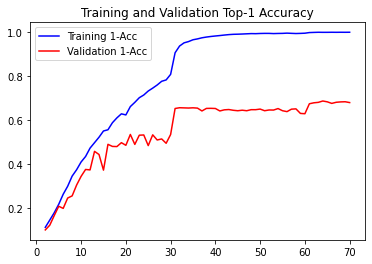

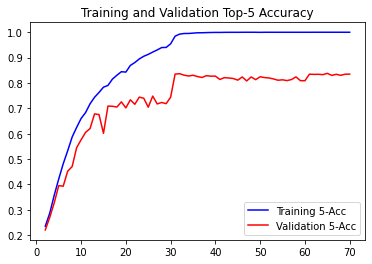

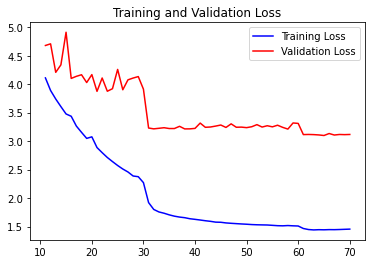

In [39]:
plt.plot(epochs[1:],acc[1:],'b',label='Training 1-Acc')
plt.plot(epochs[1:],val_acc[1:],'r',label='Validation 1-Acc')
plt.title('Training and Validation Top-1 Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs[1:],top5_acc[1:],'b',label='Training 5-Acc')
plt.plot(epochs[1:],val_top5_acc[1:],'r',label='Validation 5-Acc')
plt.title('Training and Validation Top-5 Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs[10:],loss[10:],'b',label='Training Loss')
plt.plot(epochs[10:],val_loss[10:],'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [40]:
# 이 아래는 내가 인위적으로 살펴보고 싶은 epoch에 대해서 결과값 출력

In [41]:
model=load_model(os.path.join(dir,'model_output',number,'Inception_v3','023.h5'),custom_objects={"macro_f1score": macro_f1score, "top5_acc":top5_acc, "smoothed_categorical_crossentropy":smoothed_categorical_crossentropy})

OSError: ignored

In [ ]:
# 2. epoch=?
loss , acc, top5_acc, mf1 = model.evaluate(test_generator,steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Top-1 Accuracy: %.4f / Test Top-5 Accuracy: %.4f / Test Macro f1: %.4f]\n' % (loss,acc,top5_acc,mf1))

# 2. epoch=?
smoothing_param = 0.1
var = model.evaluate(generate_test_for_two(),steps=int(len(x_test)/batch_sizes))
print('[Test Loss: %.4f /  Test Top-1 Accuracy: %.4f / Test Top-5 Accuracy: %.4f / Test Macro f1: %.4f]\n' % (var[0],var[3],var[4],var[5]))